In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

In [2]:
import plotly
import cufflinks as cf
cf.go_offline()

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
import holidays
from fbprophet import Prophet

### Methodology
1. __Loading the Data__ :<br>
The dataset given is from Tierra del fuego operations at its facilities in Europe and timeline is from July 3, 2016 to December 6,2016
<br>
***
2. __Data Processing__:<br>
Data Preprocessing to keeping data which is required for forecasting, also some features where added for Data visualization.
***
3. __Exploratory Data Analysis__:<br>
Visualizing the data, to see the sales trend and find important information from it, which will help in further analysis
***
4. __Check Seasonality, ACF, PACF__:<br>
To Study the sales pattern, trend, stationalrity
***
5. __Forecasting__:<br>
Finally Forecasting with Prophet library from Facebook
***
6. __Result__<br>

***
__Note__: The analysis related to shipping is done in tableau.<br> The tableau profile link is :
    https://public.tableau.com/profile/suyashkumar.chavan#!/vizhome/supplychainanalytics/Dashboard1

## 1. Loading the data

In [4]:
df = pd.read_excel('Data.xlsx')
df.head()

,order_id,country,shipping_method,units_per_order,facility,product_category,on_sale,transit_days,returned,backorder,datetime_ordered,datetime_sourced,datetime_product_ready,datetime_planned,datetime_delivered,deadline_source,deadline_make,deadline_deliver,delivered_to_plan
0,E00000001,UNITED KINGDOM,Ground,1,OXFORD,ACCESSORIES,Y,2,NaN,NaN,2016-07-03 03:07:29,2016-07-03 04:09:49,2016-07-06 00:59:42,2016-07-08,2016-07-07,1612,38,3,PASS
1,E00000002,FRANCE,Ground,1,ANTWERP,JACKETS & VESTS,N,3,Y,NaN,2016-07-03 00:08:43,2016-07-03 02:16:24,2016-07-03 07:17:04,2016-07-06,2016-07-05,531,8,3,PASS
2,E00000003,FRANCE,Ground,1,ANTWERP,TOPS,Y,3,NaN,NaN,2016-07-03 00:36:00,2016-07-03 02:16:18,2016-07-03 06:16:57,2016-07-06,2016-07-05,504,8,3,PASS
3,E00000004,FRANCE,Ground,1,ANTWERP,JACKETS & VESTS,Y,5,NaN,NaN,2016-07-03 00:47:45,2016-07-03 02:16:18,2016-07-03 06:16:55,2016-07-07,2016-07-05,492,8,5,PASS
4,E00000005,UNITED KINGDOM,Next Day,1,OXFORD,JACKETS & VESTS,Y,1,NaN,NaN,2016-07-03 03:52:13,2016-07-03 07:56:33,2016-07-05 08:53:19,2016-07-06,2016-07-06,1567,6,1,PASS


In [5]:
df.shape

(110114, 19)

__So we have total 110114 orders details__

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110114 entries, 0 to 110113
Data columns (total 19 columns):
order_id                  110114 non-null object
country                   110114 non-null object
shipping_method           110114 non-null object
units_per_order           110114 non-null int64
facility                  110114 non-null object
product_category          110114 non-null object
on_sale                   110114 non-null object
transit_days              110114 non-null int64
returned                  15391 non-null object
backorder                 12110 non-null object
datetime_ordered          110114 non-null datetime64[ns]
datetime_sourced          110114 non-null datetime64[ns]
datetime_product_ready    110114 non-null datetime64[ns]
datetime_planned          110114 non-null datetime64[ns]
datetime_delivered        110114 non-null datetime64[ns]
deadline_source           110114 non-null int64
deadline_make             110114 non-null int64
deadline_deliver      

__As we are doing forecasting only, we dont need many of the features,so we remove them.__

In [7]:
df = df [['order_id','datetime_ordered','facility','country','units_per_order','product_category']]
df.head()

,order_id,datetime_ordered,facility,country,units_per_order,product_category
0,E00000001,2016-07-03 03:07:29,OXFORD,UNITED KINGDOM,1,ACCESSORIES
1,E00000002,2016-07-03 00:08:43,ANTWERP,FRANCE,1,JACKETS & VESTS
2,E00000003,2016-07-03 00:36:00,ANTWERP,FRANCE,1,TOPS
3,E00000004,2016-07-03 00:47:45,ANTWERP,FRANCE,1,JACKETS & VESTS
4,E00000005,2016-07-03 03:52:13,OXFORD,UNITED KINGDOM,1,JACKETS & VESTS


1.__order_id__: Unique order id for each order<br>
2.__datetime_ordered__: Date & time when each order is placed<br>
3.__Facility__: Location of Facility from which order is dispached, Each facility covers specific locations across Europe so customers across the europe are distributed across these facilities <br>
4.__country__: Country from which order is placed(__Note__:Not the country in which facility is located)<br>
5.__Units_per_order_: Number of units ordered per order<br>
6.__product_category__: Type of product ordered. 3 types of product category:1.Accessories,2.Jackers and vets 3.Tops<br>    

To find the shopping trend of customers, I will add more features related to day of week, week of the year, also state holiday in perticular country from which order os placed

## 2. Data Processing

In [11]:
def is_hoilday(columns):
    date = columns[0]
    country = columns[1]
    
    if country =='UNITED KINGDOM':
        if date in holidays.UK():
            return 1
        else:
            return 0
        
    if country == 'FRANCE':
        if date in holidays.France():
            return 1
        else:
            return 0
        
    if country == 'GERMANY':
        if date in holidays.Germany():
            return 1
        else:
            return 0
        
    if country == 'SWEDEN':
        if date in holidays.Sweden():
            return 1
        else:
            return 0
        
    if country == 'BELGIUM':
        if date in holidays.Belgium():
            return 1
        else:
            return 0
    if country =='NETHERLANDS':
        if date in holidays.Netherlands():
            return 1
        else:
            return 0

In [12]:
df['State_holiday'] = df[['datetime_ordered','country']].apply(is_hoilday,axis=1)
df['State_holiday'].value_counts()

0    108373
1      1741
Name: State_holiday, dtype: int64

The sales on holidays is very low, which I wasn't expecting this, but its good to check holidays as Prophet consider holidays for forecsting purpose.

In [13]:
df['hour_of_day'] = df['datetime_ordered'].apply(lambda x:x.hour)
df['day_of_week'] = df['datetime_ordered'].apply(lambda x : x.dayofweek)
df['day_of_month'] = df['datetime_ordered'].apply(lambda x: x.day)
df['Week_of_year'] = df['datetime_ordered'].apply(lambda x:x.weekofyear)
df['month_of_year'] = df['datetime_ordered'].apply(lambda x:x.month)

In [14]:
df['datetime_ordered'] = df['datetime_ordered'].apply(lambda x:pd.to_datetime(str(x).split(' ')[0]))

In [16]:
df.head()

,order_id,datetime_ordered,facility,country,units_per_order,product_category,State_holiday,hour_of_day,day_of_week,day_of_month,Week_of_year,month_of_year
0,E00000001,2016-07-03,OXFORD,UNITED KINGDOM,1,ACCESSORIES,0,3,6,3,26,7
1,E00000002,2016-07-03,ANTWERP,FRANCE,1,JACKETS & VESTS,0,0,6,3,26,7
2,E00000003,2016-07-03,ANTWERP,FRANCE,1,TOPS,0,0,6,3,26,7
3,E00000004,2016-07-03,ANTWERP,FRANCE,1,JACKETS & VESTS,0,0,6,3,26,7
4,E00000005,2016-07-03,OXFORD,UNITED KINGDOM,1,JACKETS & VESTS,0,3,6,3,26,7


## 3.Exploratory Data Analysis

In [17]:
dd=df.groupby(['datetime_ordered','facility']).sum().reset_index()[['datetime_ordered','facility','units_per_order']]
dd.pivot_table(columns='facility',index='datetime_ordered').fillna(0).iplot(xTitle = 'Time',yTitle='Sales/Day',title='Sales/Day')

In [1]:
from IPython.display import Image

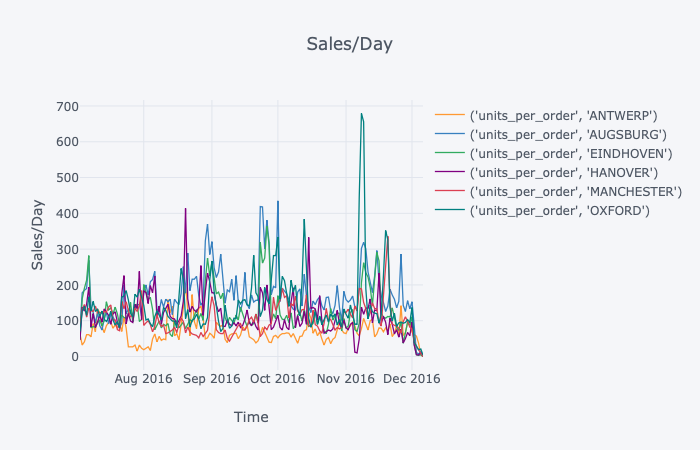

In [2]:
Image(filename='newplot.png')

In [18]:
ddd=df.groupby(['datetime_ordered','product_category']).sum().reset_index()[['datetime_ordered','product_category','units_per_order']]
ddd.pivot_table(columns='product_category',index='datetime_ordered').fillna(0).iplot(xTitle = 'Time',yTitle='Sales/Day',title='Sales/Day(Per Product)')

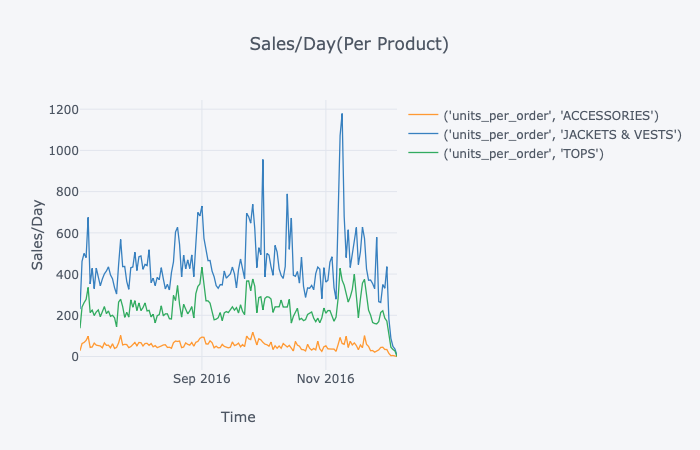

In [3]:
Image(filename='newplot-2.png')

In [20]:
df.groupby(['facility','hour_of_day']).sum()['units_per_order'].reset_index().pivot_table(columns = 'facility',index='hour_of_day').iplot(xTitle='Hour of the Day',yTitle='Total Sales',title='Sales/Hour(Total)')

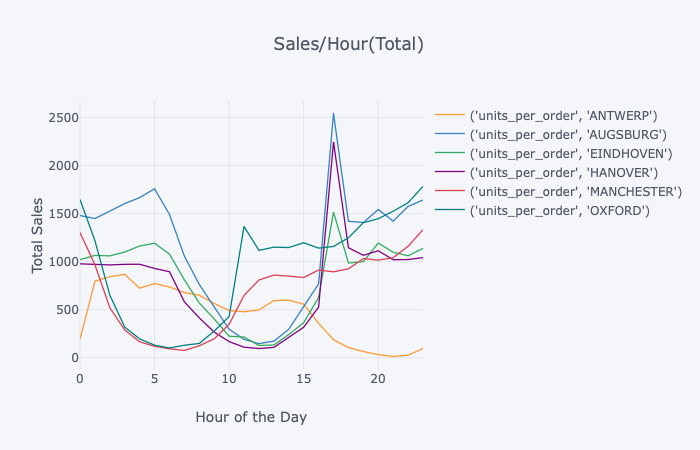

In [4]:
Image(filename='newplot-4.png')

In [21]:
df.groupby(['facility','Week_of_year']).sum()['units_per_order'].reset_index().pivot_table(columns = 'facility',index='Week_of_year').iplot(title='Number of Sales per week',xTitle='Week of Year',yTitle='Number of orders')

In [22]:
df=df[df['month_of_year']!=12]

Text(0.5, 0, 'is it holiday')

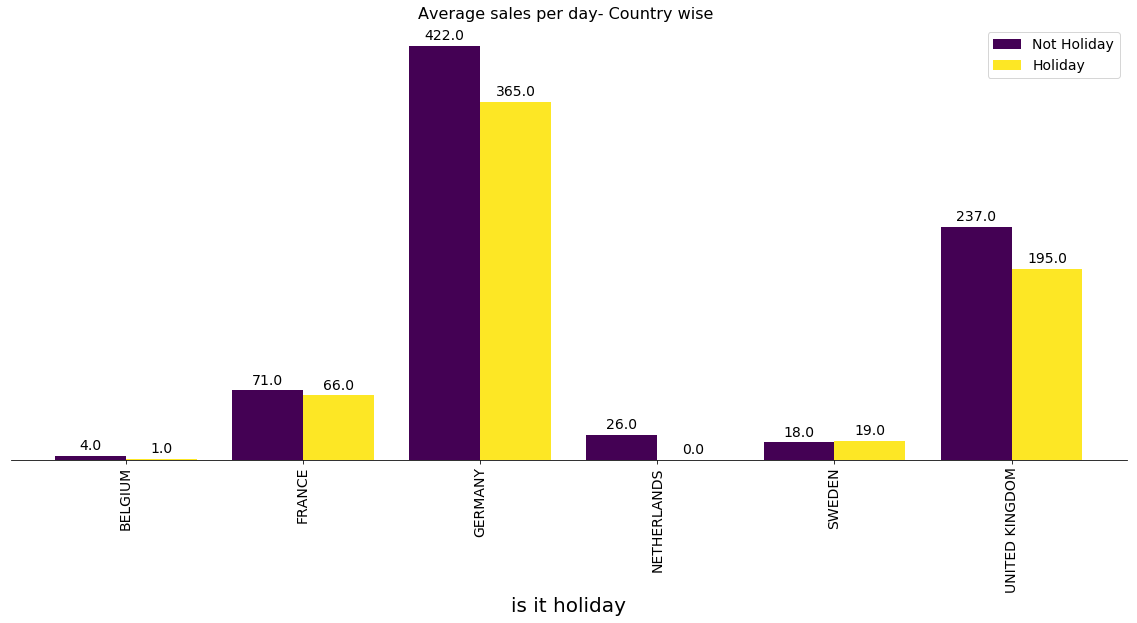

In [23]:
hol=df.groupby(['country','State_holiday','datetime_ordered']).sum().reset_index().groupby(['country','State_holiday']).mean()['units_per_order'].reset_index().pivot_table(index='country',columns='State_holiday')
hol.columns = ['Not Holiday','Holiday']
ax = hol.plot(kind='bar', 
            figsize=(20, 8), 
            width=0.8, 
            cmap='viridis',
           )
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.set_title("Average sales per day- Country wise ", fontsize=16)
for p in ax.patches:
    ax.annotate(np.round(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )
plt.xlabel('is it holiday',fontsize=20)

In [24]:
sales=df.groupby(['facility','datetime_ordered','day_of_week','Week_of_year','product_category']).sum()['units_per_order'].reset_index()
sales.columns = ['Facility','Date','Day_of_week','Week_of_year','Product','Sales']
sales.head(10)

,Facility,Date,Day_of_week,Week_of_year,Product,Sales
0,ANTWERP,2016-07-03,6,26,ACCESSORIES,4
1,ANTWERP,2016-07-03,6,26,JACKETS & VESTS,32
2,ANTWERP,2016-07-03,6,26,TOPS,26
3,ANTWERP,2016-07-04,0,27,ACCESSORIES,1
4,ANTWERP,2016-07-04,0,27,JACKETS & VESTS,25
5,ANTWERP,2016-07-04,0,27,TOPS,6
6,ANTWERP,2016-07-05,1,27,JACKETS & VESTS,26
7,ANTWERP,2016-07-05,1,27,TOPS,15
8,ANTWERP,2016-07-06,2,27,ACCESSORIES,7
9,ANTWERP,2016-07-06,2,27,JACKETS & VESTS,35


Text(0.5, 0, 'Facilities')

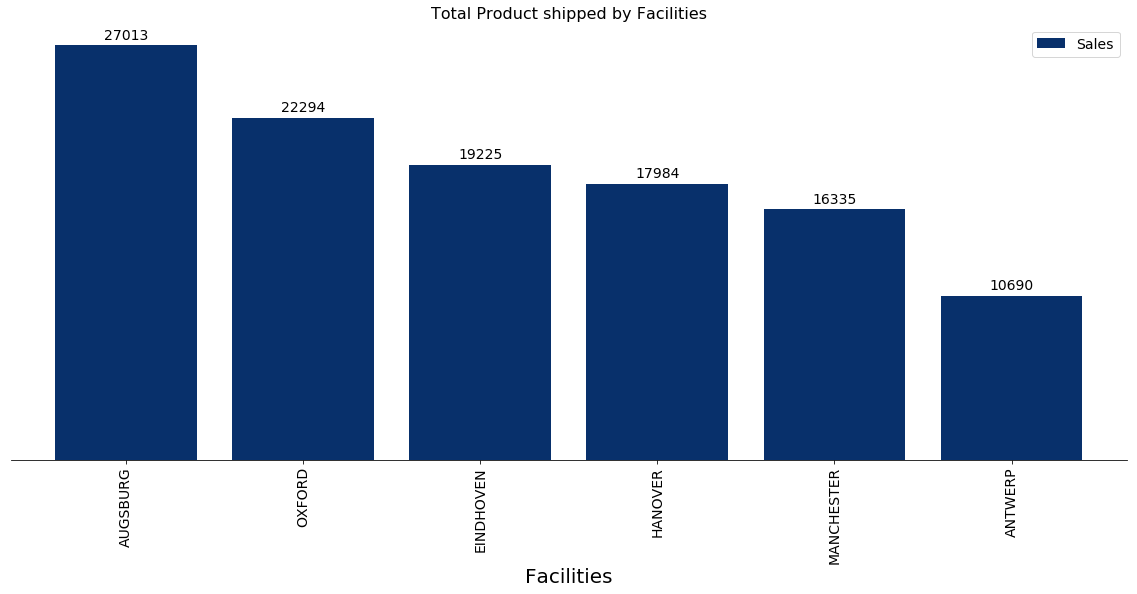

In [25]:
aa = sales.groupby('Facility').sum().sort_values('Sales',ascending=False)['Sales']
ax = aa.plot(kind='bar', 
            figsize=(20, 8), 
            width=0.8, 
            cmap='Blues_r',
           )
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.set_title("Total Product shipped by Facilities", fontsize=16)
for p in ax.patches:
    ax.annotate(np.round(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )
plt.xlabel('Facilities',fontsize=20)

Text(0.5, 0, 'Facility')

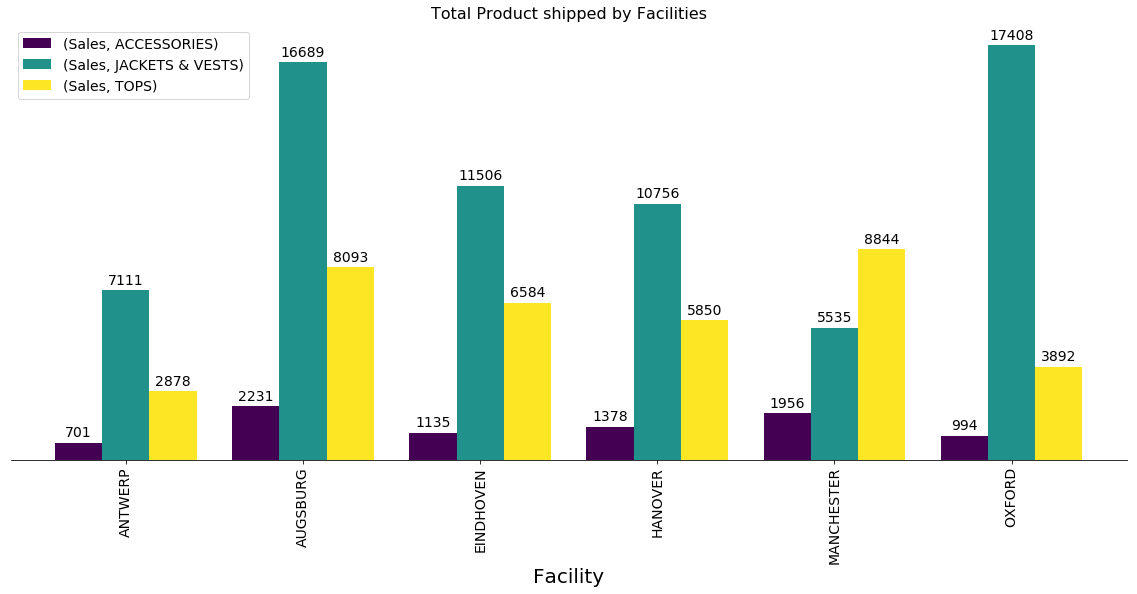

In [26]:
a = sales.groupby(['Facility','Product']).sum()['Sales'].reset_index()
a=a.pivot_table(index='Facility',columns='Product')
ax = a.plot(kind='bar', 
            figsize=(20, 8), 
            width=0.8, 
            cmap='viridis',
           )
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.set_title("Total Product shipped by Facilities", fontsize=16)
for p in ax.patches:
    ax.annotate(np.round(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )
plt.xlabel('Facility',fontsize=20)

Text(0.5, 0, 'Facility')

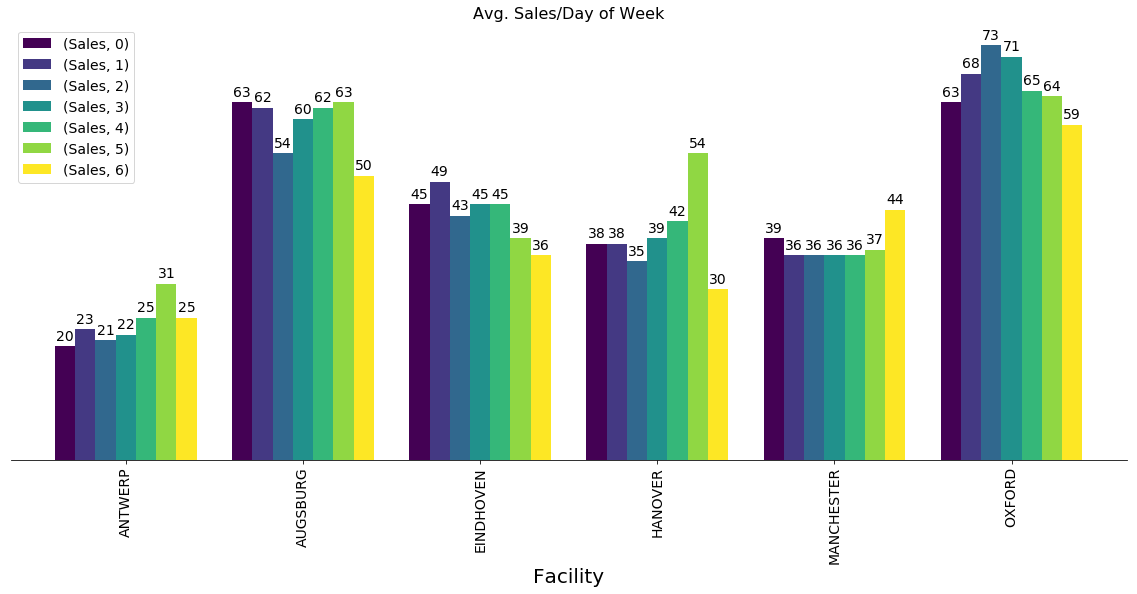

In [27]:
aaa=sales.groupby(['Facility','Day_of_week']).mean()['Sales'].reset_index().pivot_table(index='Facility',columns='Day_of_week')
for i in aaa.columns:
    aaa[i] = aaa[i].apply(int)
ax = aaa.plot(kind='bar', 
            figsize=(20, 8), 
            width=0.8, 
            cmap='viridis',
           )
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.set_title("Avg. Sales/Day of Week", fontsize=16)
for p in ax.patches:
    ax.annotate(np.round(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )
plt.xlabel('Facility',fontsize=20)

### Separating dataset according to Facility

In [28]:
sales['Sales'] = sales['Sales']*1.0

In [29]:
sales_antwerp = sales[sales['Facility']=='ANTWERP']
sales_Augsburg = sales[sales['Facility']=='AUGSBURG']
sales_eindhoven = sales[sales['Facility']=='EINDHOVEN']
sales_hanover = sales[sales['Facility']=='HANOVER']
sales_manchester = sales[sales['Facility']=='MANCHESTER']
sales_oxford = sales[sales['Facility']=='OXFORD']

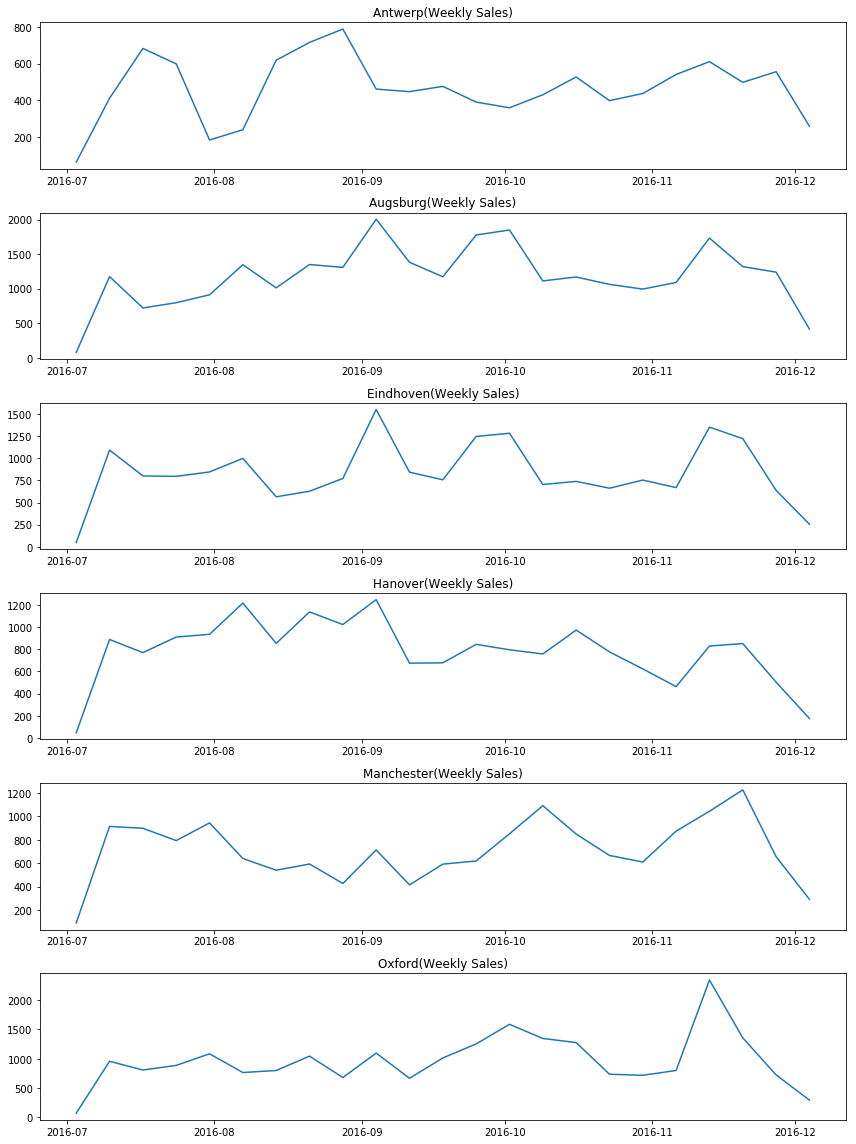

In [30]:
plt.figure(figsize=(12,16))
gs = GridSpec(6,1)


ax = plt.subplot(gs[0])
plt.plot(sales_antwerp.set_index('Date').resample('W').sum()['Sales'])
ax.set(title='Antwerp(Weekly Sales)')

ax1 = plt.subplot(gs[1])
plt.plot(sales_Augsburg.set_index('Date').resample('W').sum()['Sales'])
ax1.set(title='Augsburg(Weekly Sales)')

ax2 = plt.subplot(gs[2])
plt.plot(sales_eindhoven.set_index('Date').resample('W').sum()['Sales'])
ax2.set(title='Eindhoven(Weekly Sales)')

ax3 = plt.subplot(gs[3])
plt.plot(sales_hanover.set_index('Date').resample('W').sum()['Sales'])
ax3.set(title='Hanover(Weekly Sales)')

ax4 = plt.subplot(gs[4])
plt.plot(sales_manchester.set_index('Date').resample('W').sum()['Sales'])
ax4.set(title='Manchester(Weekly Sales)')

ax5 = plt.subplot(gs[5])
plt.plot(sales_oxford.set_index('Date').resample('W').sum()['Sales'])
ax5.set(title='Oxford(Weekly Sales)')
plt.tight_layout()

In [32]:
sales_antwerp2 = sales_antwerp.groupby('Date').sum()['Sales']
sales_Augsburg2 = sales_Augsburg.groupby('Date').sum()['Sales']
sales_eindhoven2 = sales_eindhoven.groupby('Date').sum()['Sales']
sales_hanover2 = sales_hanover.groupby('Date').sum()['Sales']
sales_manchester2=sales_manchester.groupby('Date').sum()['Sales']
sales_oxford2 = sales_oxford.groupby('Date').sum()['Sales']

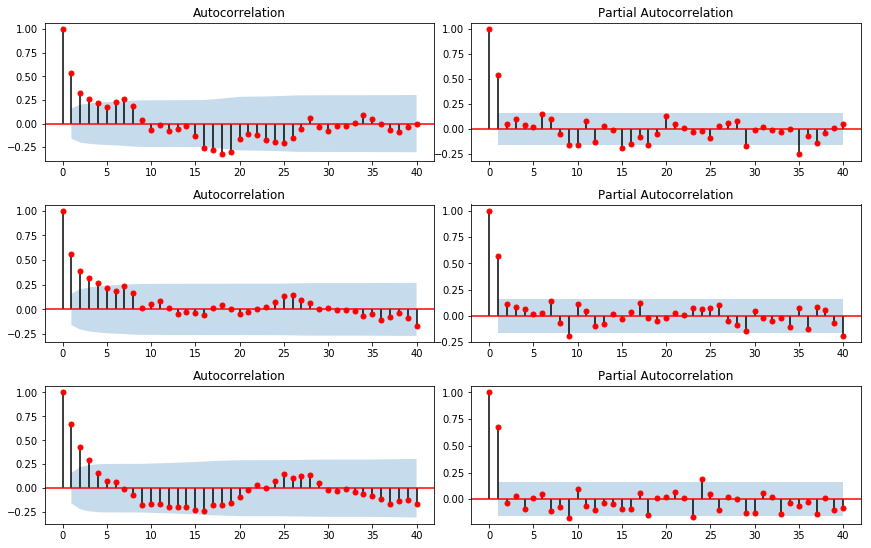

In [35]:
plt.figure(figsize=(12,10))


plt.subplot(421);plot_acf(sales_antwerp2, lags = 40, ax = plt.gca(), color = 'r')
plt.subplot(422); plot_pacf(sales_antwerp2, lags = 40, ax = plt.gca(), color = 'r')

plt.subplot(423);plot_acf(sales_Augsburg2, lags = 40, ax = plt.gca(), color = 'r')
plt.subplot(424); plot_pacf(sales_Augsburg2, lags = 40, ax = plt.gca(), color = 'r')


plt.subplot(425);plot_acf(sales_eindhoven2, lags = 40, ax = plt.gca(), color = 'r')
plt.subplot(426); plot_pacf(sales_eindhoven2, lags = 40, ax = plt.gca(), color = 'r')
plt.tight_layout()

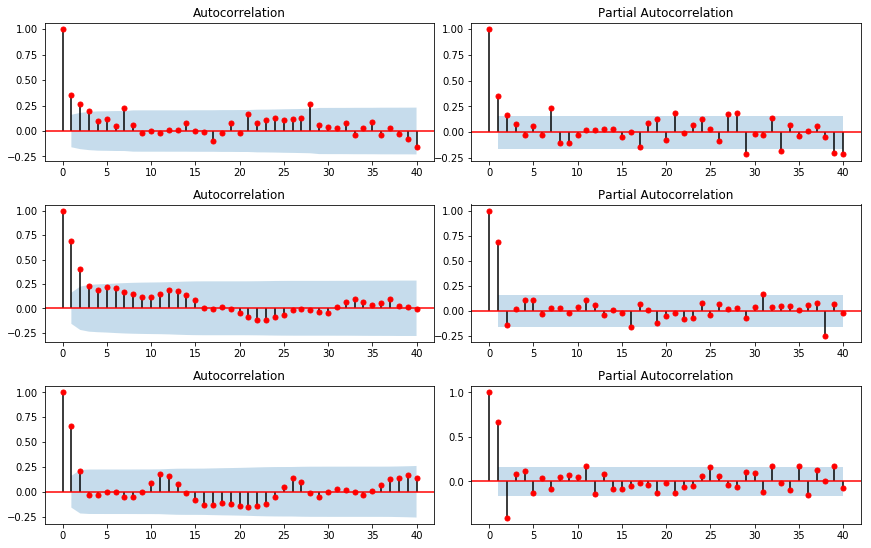

In [36]:
plt.figure(figsize=(12,10))
plt.subplot(421);plot_acf(sales_hanover2, lags = 40, ax = plt.gca(), color = 'r')
plt.subplot(422); plot_pacf(sales_hanover2, lags = 40, ax = plt.gca(), color = 'r')

plt.subplot(423);plot_acf(sales_manchester2, lags = 40, ax = plt.gca(), color = 'r')
plt.subplot(424); plot_pacf(sales_manchester2, lags = 40, ax = plt.gca(), color = 'r')

plt.subplot(425);plot_acf(sales_oxford2, lags = 40, ax = plt.gca(), color = 'r')
plt.subplot(426); plot_pacf(sales_oxford2, lags = 40, ax = plt.gca(), color = 'r')
plt.tight_layout()

## 5.Forecasting

__For Forecasting instead of using Cross-validation(In-build in prophet), I have manually added seasonality for forcasting of each facility according to the sales pattern
so seasonality which you will see below for each facility is acheived after trying several times to find best periods__

In [37]:
sales_antwerp2 = sales_antwerp2.reset_index()
sales_antwerp2.columns=['ds','y']

sales_Augsburg2 = sales_Augsburg2.reset_index()
sales_Augsburg2.columns=['ds','y']

sales_eindhoven2 = sales_eindhoven2.reset_index()
sales_eindhoven2.columns=['ds','y']

sales_hanover2 = sales_hanover2.reset_index()
sales_hanover2.columns=['ds','y']

sales_manchester2 = sales_manchester2.reset_index()
sales_manchester2.columns=['ds','y']

sales_oxford2 = sales_oxford2.reset_index()
sales_oxford2.columns=['ds','y']

In [38]:
## Function to calculate Mean Absolute Percentage Error
def mape(y_true,y_pred):
    y_true , y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

### 5.1 Antwerp 

In [40]:
model_ant = Prophet(interval_width=0.95,n_changepoints=200,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=30).add_seasonality(name='4 days',period=4,fourier_order=24).add_seasonality(name='60 days',period=60,fourier_order=40).add_seasonality(name='15 days',period=15,fourier_order=35).add_seasonality(name='24 days',period=24,fourier_order=17)
model_ant.fit(sales_antwerp2)

future_dates_ant = model_ant.make_future_dataframe(periods=4*7)   # Forecasting for 4 weeks
forecast_ant = model_ant.predict(future_dates_ant)
forecast_ant[['ds','yhat','yhat_lower','yhat_upper']].tail()
mape_ant =mape(sales_antwerp2['y'],forecast_ant.loc[:150]['yhat'])
print('MAPE for Antwerp: {}'.format(mape_ant))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 119.


MAPE for Antwerp: 13.835104120299189


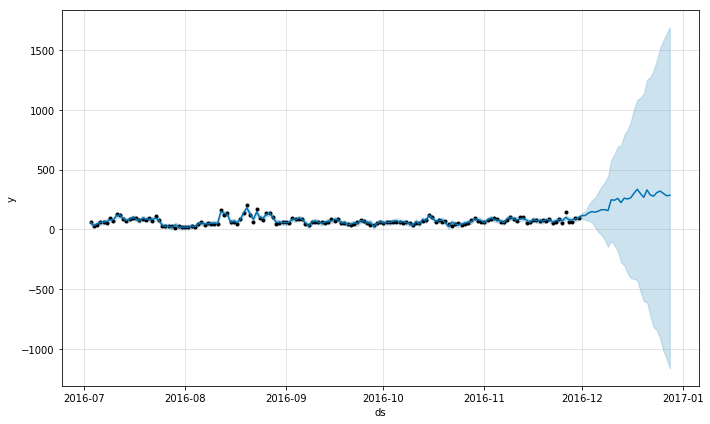

In [41]:
fig_ant = model_ant.plot(forecast_ant)

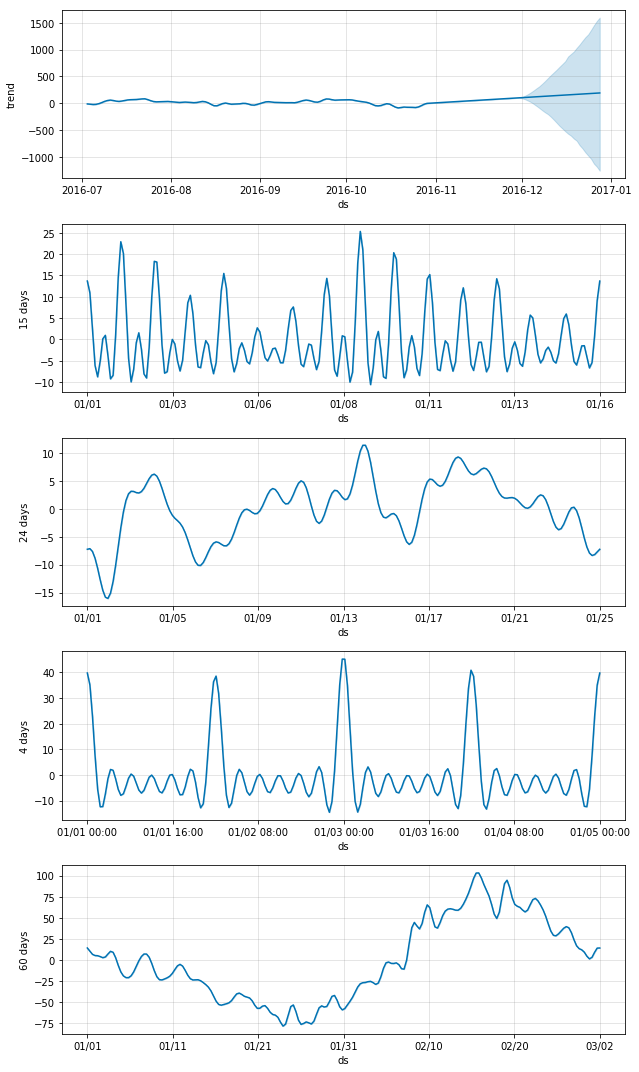

In [42]:
fig_ant_comp =  model_ant.plot_components(forecast_ant)

### 5.2 Augsburg

In [43]:
model_aug = Prophet(interval_width=0.95,n_changepoints=200,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=20).add_seasonality(name='5 days',period=5,fourier_order=30).add_seasonality(name='35 days',period=35,fourier_order=40).add_seasonality(name='10 days',period=10,fourier_order=30).add_seasonality(name='22 days',period=22,fourier_order=15)
model_aug.fit(sales_Augsburg2)

future_dates_aug = model_aug.make_future_dataframe(periods=4*7)   # Forecasting for 4 weeks
forecast_aug = model_aug.predict(future_dates_aug)
forecast_aug[['ds','yhat','yhat_lower','yhat_upper']].tail()

mape_aug = mape(sales_Augsburg2['y'],forecast_aug.loc[:150]['yhat'])
print('MAPE for Augsburg: {}'.format(mape_aug))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 119.
/Users/suyashchavan/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



MAPE for Augsburg: 11.271830832068506


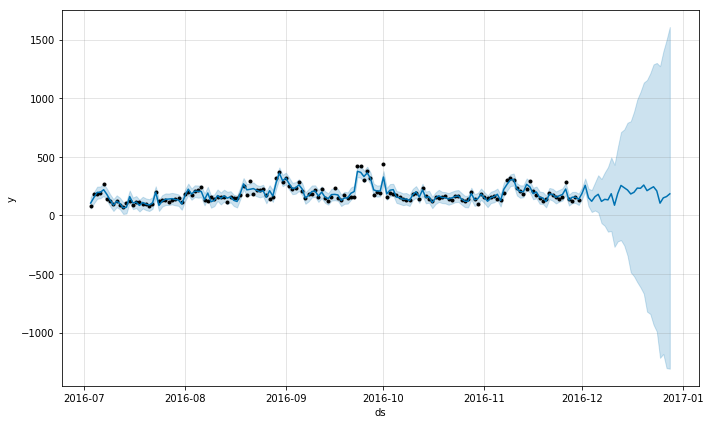

In [44]:
fig = model_aug.plot(forecast_aug)

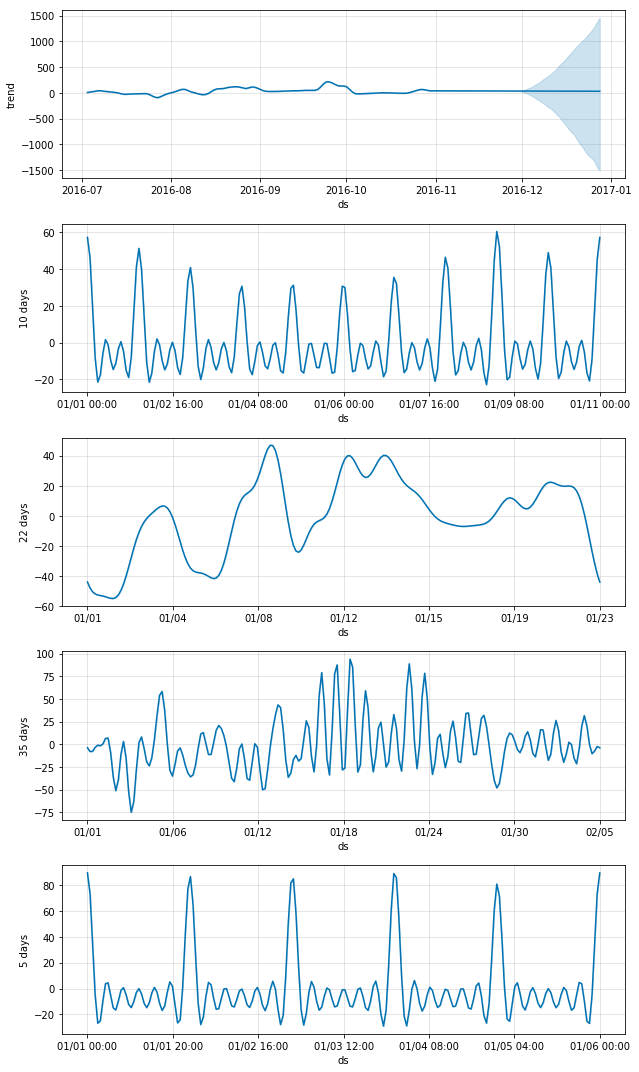

In [45]:
fig = model_aug.plot_components(forecast_aug)

### 5.3 Eindhoven

In [47]:
model_eind = Prophet(interval_width=0.95,n_changepoints=200,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=20).add_seasonality(name='27 days',period=27,fourier_order=30).add_seasonality(name='4 days',period=4,fourier_order=10).add_seasonality(name='20 days',period=20,fourier_order=30)
model_eind.fit(sales_eindhoven2)

future_dates_eind = model_eind.make_future_dataframe(periods=4*7)   # Forecasting for 4 weeks
forecast_eind = model_eind.predict(future_dates_eind)
forecast_eind[['ds','yhat','yhat_lower','yhat_upper']].tail()

mape_eind = mape(sales_eindhoven2['y'],forecast_eind.loc[:150]['yhat'])
print('MAPE for Eindhoven: {}'.format(mape_eind))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 119.


MAPE for Eindhoven: 14.746451555561912


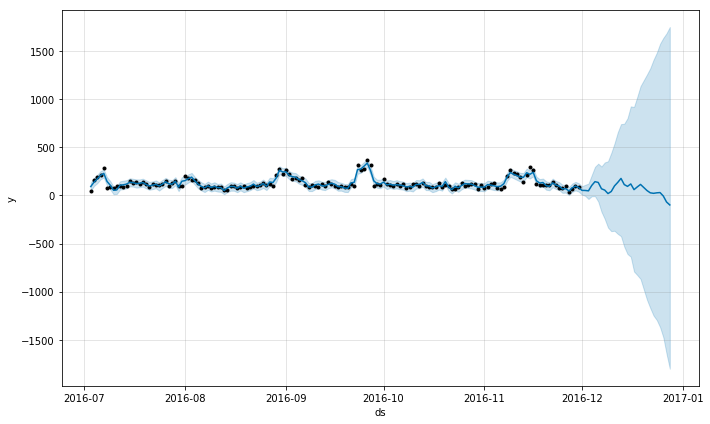

In [48]:
fig = model_eind.plot(forecast_eind)

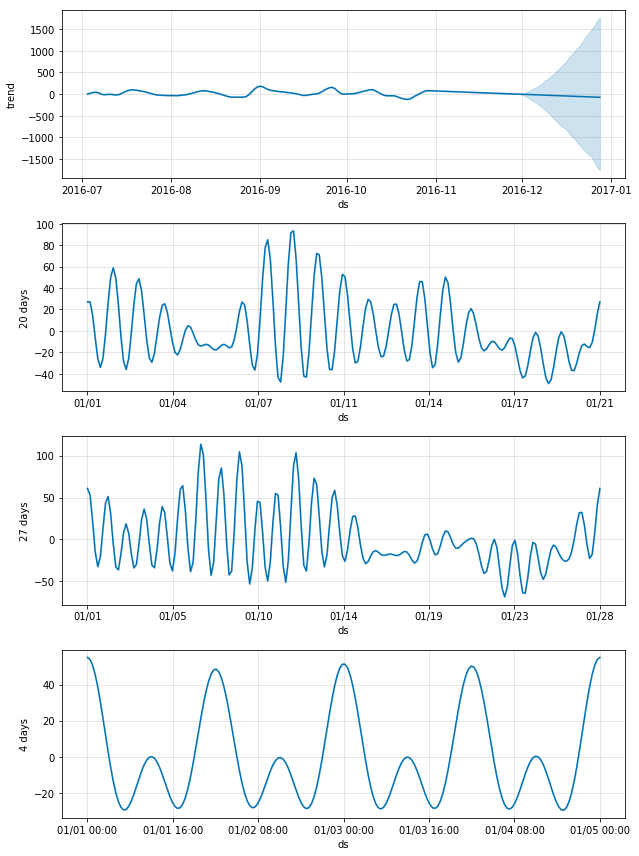

In [49]:
fig = model_eind.plot_components(forecast_eind)

### 5.4 Oxford

In [51]:
model_oxf = Prophet(interval_width=0.95,n_changepoints=200,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=20).add_seasonality(name='27 days',period=27,fourier_order=25).add_seasonality(name='4 days',period=4,fourier_order=10).add_seasonality(name='20 days',period=20,fourier_order=25)
model_oxf.fit(sales_oxford2)

future_dates_oxf = model_oxf.make_future_dataframe(periods=4*7)   # Forecasting for 4 weeks
forecast_oxf = model_oxf.predict(future_dates_oxf)

mape_oxf= mape(sales_oxford2['y'],forecast_oxf.loc[:150]['yhat'])
print('MAPE for Oxford: {}'.format(mape_oxf))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 119.


MAPE for Oxford: 17.81780524930823


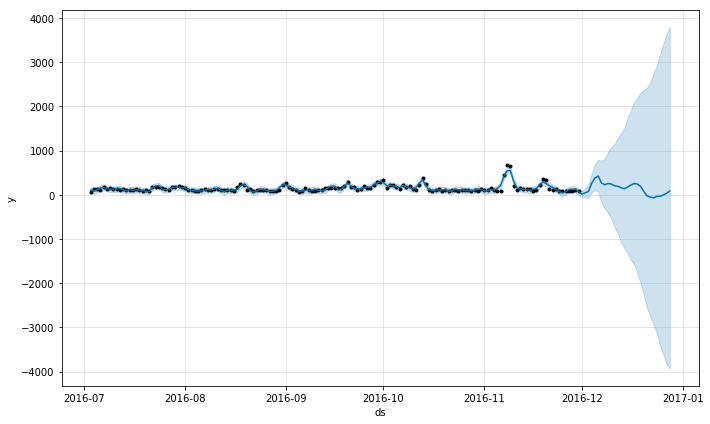

In [52]:
fig = model_oxf.plot(forecast_oxf)

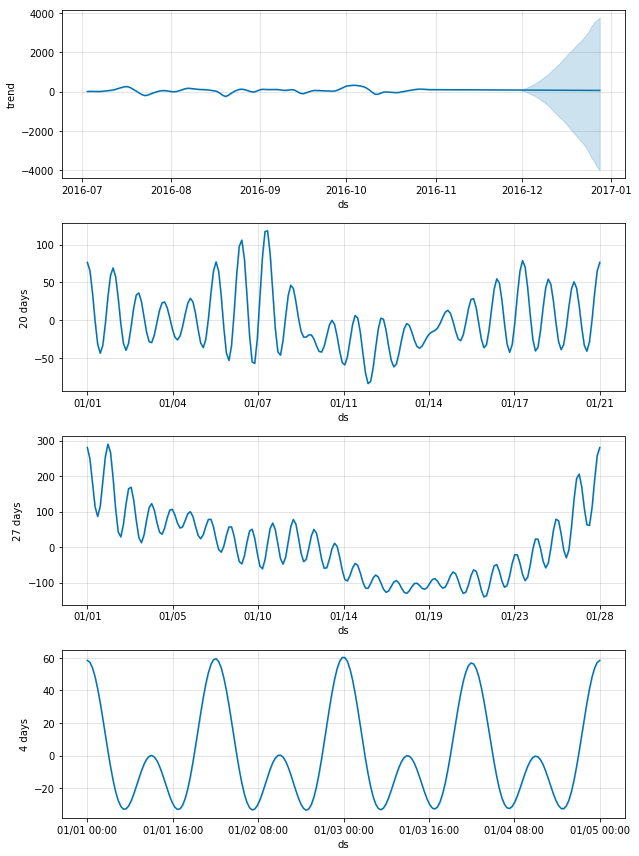

In [53]:
fig = model_oxf.plot_components(forecast_oxf)

### 5.5 Hanover

In [55]:
model_han = Prophet(interval_width=0.95,n_changepoints=200,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=20).add_seasonality(name='45 days',period=45,fourier_order=25).add_seasonality(name='4 days',period=4,fourier_order=20).add_seasonality(name='12 days',period=12,fourier_order=25)
model_han.fit(sales_hanover2)

future_dates_han = model_han.make_future_dataframe(periods=4*7)   # Forecasting for 4 weeks
forecast_han = model_han.predict(future_dates_han)

mape_han= mape(sales_hanover2['y'],forecast_han.loc[:150]['yhat'])
print('MAPE for Hanover: {}'.format(mape_han))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 119.


MAPE for Hanover: 16.177172296411214


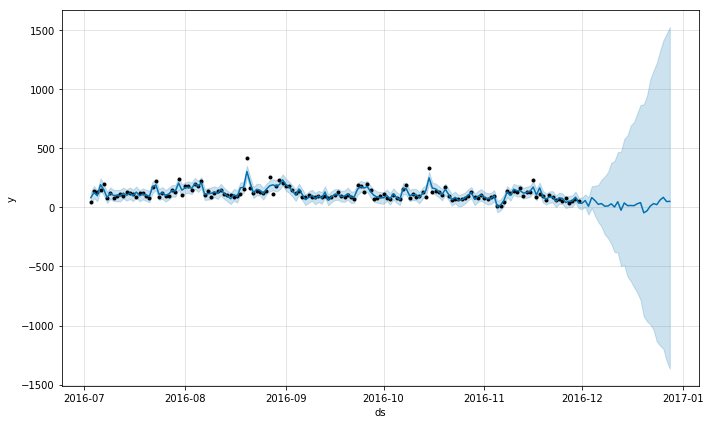

In [56]:
fig = model_han.plot(forecast_han)

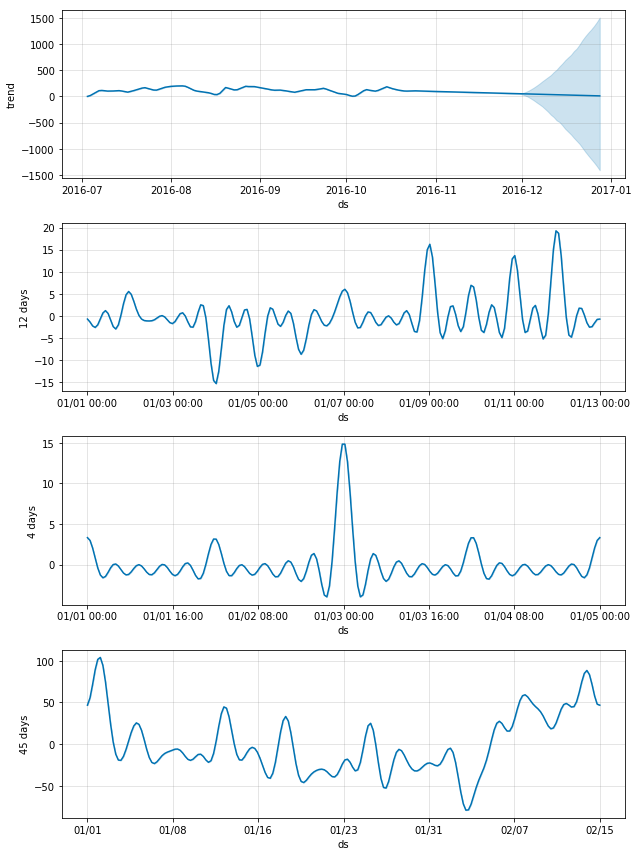

In [57]:
fig = model_han.plot_components(forecast_han)

## 6. Results

__1.The Results which i have got can be improved further with trial and error, but I have decided to stop because it may cause overfitting.__<br>
***
__2.More data would have been more helpful, as yearly seasonality can help model to learn more about data and larger the data better it is for forecasting.__
***
__3.The result which I have got are better than traditional moving average, exponential smoothing Methods(That analysis is done in excel).__